# ABCD Yields

In [1]:
import uproot
import numpy as np

In [2]:
def get_abcd(file, tree="Events", BDT_CUT=0.56, DNN_CUT=0.92):
    with uproot.open(file) as f:
        df = f.get(tree).arrays(library="pd")

    a = df.query("VBSBDTscore > @BDT_CUT & abcdnet_score > @DNN_CUT").weight
    b = df.query("VBSBDTscore > @BDT_CUT & abcdnet_score < @DNN_CUT").weight
    c = df.query("VBSBDTscore < @BDT_CUT & abcdnet_score > @DNN_CUT").weight
    d = df.query("VBSBDTscore < @BDT_CUT & abcdnet_score < @DNN_CUT").weight

    err_a = np.sqrt((a**2).sum())
    err_b = np.sqrt((b**2).sum())
    err_c = np.sqrt((c**2).sum())
    err_d = np.sqrt((d**2).sum())

    a = a.sum()
    b = b.sum()
    c = c.sum()
    d = d.sum()

    if "data_MVA" in file:
        a = np.array(1)

    print(f"Actual A: {a} \\pm {err_a}")
    print(f"Region B: {b} \\pm {err_b}")
    print(f"Region C: {c} \\pm {err_c}")
    print(f"Region D: {d} \\pm {err_d}")

    err_pwhite_a = np.sqrt((err_b * c / d) ** 2 + (err_c * b / d) ** 2 + ((b * c / d**2) * err_d) ** 2)

    print(f"Predicted A: {b * c / d} \\pm {err_pwhite_a}")

    return a, b, c, d

# DATA

In [7]:
data = get_abcd("/data/userdata/aaarora/output/run2/ABCDNet_simpleDisco_VBSVVH1lep_30/output/data_MVA_abcdnet.root")

Actual A: 1 \pm 1.0
Region B: 78.0 \pm 8.831760866327848
Region C: 11.0 \pm 3.3166247903554
Region D: 1013.0 \pm 31.827660925679098
Predicted A: 0.8469891411648569 \pm 0.27408543816219094


# SIG

In [5]:
sig = get_abcd("/data/userdata/aaarora/output/run2/ABCDNet_simpleDisco_VBSVVH1lep_30/output/sig_MVA_abcdnet.root")

Actual A: 3.6517075212992065 \pm 0.024828333321467416
Region B: 1.1678695583992402 \pm 0.01533716805981005
Region C: 0.8593609774220464 \pm 0.012581330951505421
Region D: 0.5358977092893433 \pm 0.01127617799766611
Predicted A: 1.8727856227232849 \pm 0.05394000178326641


# BKG

In [5]:
bkg = get_abcd("/data/userdata/aaarora/output/run2/ABCDNet_simpleDisco_VBSVVH1lep_30/output/bkg_MVA_abcdnet.root")

Actual A: 1.2359898521135704 \pm 0.28876614142373974
Region B: 68.58082263645221 \pm 3.6847830872037832
Region C: 18.339941993191836 \pm 1.8086390110876318
Region D: 994.1553952537521 \pm 11.205342569775521
Predicted A: 1.265162684830447 \pm 0.14279680624627886


Text(0.5, 87.0, 'Mean: 0.01\nStd: 0.29')

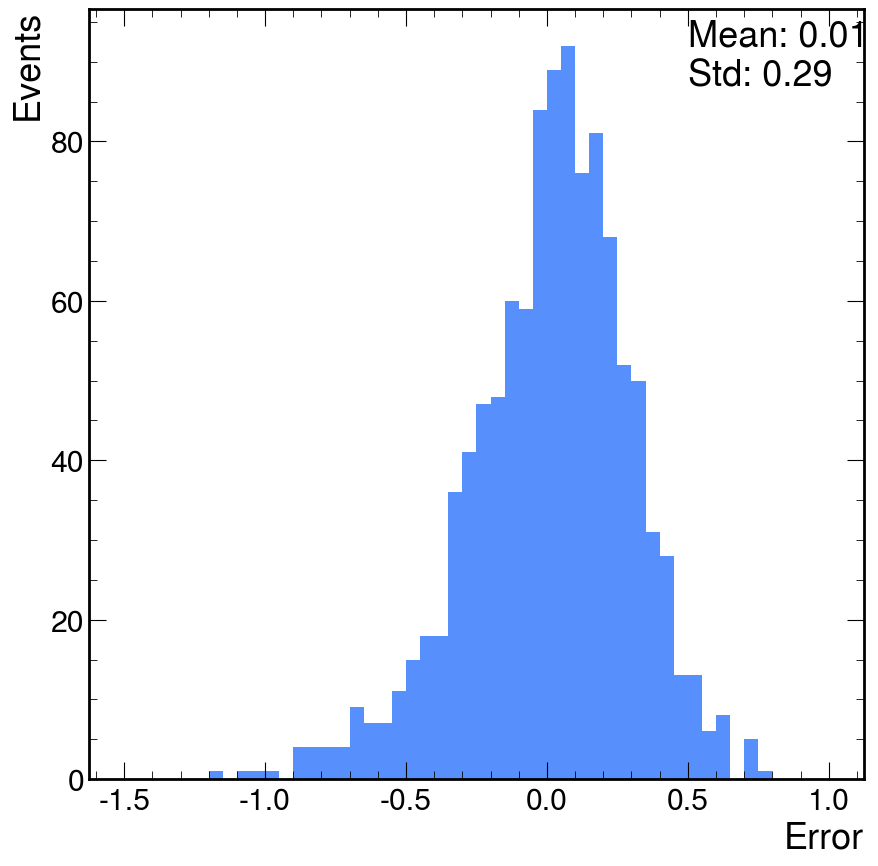

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use(hep.style.CMS)
import hist

def get_abcd_scan(file, tree="Events"):
    with uproot.open(file) as f:
        df = f.get(tree).arrays(library="pd")

    BDT_CUT = 0.56
    DNN_CUT = 0.92

    df = df.query("VBSBDTscore < @BDT_CUT & abcdnet_score < @DNN_CUT")

    errs = []

    N_SCAN = 50

    for dnn_cut in np.linspace(0, DNN_CUT, N_SCAN):
        for bdt_cut in np.linspace(0, BDT_CUT, N_SCAN):
            a = df.query("VBSBDTscore > @bdt_cut & abcdnet_score > @dnn_cut").weight.sum()
            b = df.query("VBSBDTscore > @bdt_cut & abcdnet_score < @dnn_cut").weight.sum()
            c = df.query("VBSBDTscore < @bdt_cut & abcdnet_score > @dnn_cut").weight.sum()
            d = df.query("VBSBDTscore < @bdt_cut & abcdnet_score < @dnn_cut").weight.sum()

            if d == 0:
                continue
            
            pred_a = b * c / d

            if a == 0 or pred_a == 0:
                continue

            errs.append(2*(a-pred_a)/(a+pred_a))

    return errs

errs = get_abcd_scan("/data/userdata/aaarora/output/run2/ABCDNet_simpleDisco_VBSVVH1lep_30/output/data_MVA_abcdnet.root")

h = hist.Hist.new.Reg(50, -1.5, 1, name="err").Double()
h.fill(errs)

fig, ax = plt.subplots()
hep.histplot(h, histtype="fill", ax=ax)
ax.set_xlabel("Error")
ax.set_ylabel("Events")

# add box with mean and std
mean = np.mean(errs)
std = np.std(errs)

ax.text(0.5, max(h.counts())-5, f"Mean: {mean:.2f}\nStd: {std:.2f}")